<a href="https://colab.research.google.com/github/almurillo/Metamask_Swap_Fees/blob/main/Metamask_Swap_Fees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Authenticate with Google Cloud Platform to run BigQuery queries
from google.colab import auth
auth.authenticate_user()

In [2]:
%%bigquery resulting_df --project metamask-swaps
DECLARE from_date DATE DEFAULT DATE("2022-06-01");
DECLARE to_date DATE DEFAULT DATE("2022-06-30");
WITH
  TBL AS (
  SELECT
    DATE(traces.block_timestamp) Block_Date,
    COUNT(DISTINCT traces.transaction_hash) AS Fee_Count,
    SUM(CAST(traces.value AS FLOAT64)) AS Eth_Fees
  FROM
    `bigquery-public-data.crypto_ethereum.traces` traces
  LEFT JOIN
    `bigquery-public-data.crypto_ethereum.transactions` transactions
  ON
    traces.transaction_hash = transactions.HASH
  WHERE
    transactions.to_address = '0x881d40237659c251811cec9c364ef91dc08d300c'
    AND transactions.from_address != '0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb'
    AND traces.to_address = '0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb'
    AND DATE(traces.block_timestamp) BETWEEN from_date
    AND to_date
    AND traces.value > 0
    AND traces.status = 1
  GROUP BY
    1
  UNION ALL
  SELECT
    DATE(transfers.block_timestamp) Block_Date,
    COUNT(DISTINCT transfers.transaction_hash) Fee_Count,
    SUM(CAST(transfers.value AS FLOAT64)) Eth_Fees
  FROM
    `bigquery-public-data.ethereum_blockchain.live_token_transfers` transfers
  JOIN
    `bigquery-public-data.crypto_ethereum.transactions` transactions
  ON
    transfers.transaction_hash = transactions.HASH
  WHERE
    transactions.to_address = '0x881d40237659c251811cec9c364ef91dc08d300c'
    AND transfers.to_address = '0x11ededebf63bef0ea2d2d071bdf88f71543ec6fb'
    AND transfers.token_address = '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'
    AND DATE(transfers.block_timestamp) BETWEEN from_date
    AND to_date
    AND transactions.receipt_status = 1
  GROUP BY
    1 )
SELECT
  DISTINCT t1.Block_Date,
  SUM(CAST(t1.Eth_Fees AS FLOAT64)/1000000000000000000) AS ETH_FEES,
  SUM(CAST(t1.Eth_Fees AS FLOAT64)/1000000000000000000)/SUM(t1.fee_count) AS AVG_ETH_FEES,
  SUM(SUM(CAST(t1.Eth_Fees AS FLOAT64)/1000000000000000000)) OVER (ORDER BY t1.block_date) AS Accummulative_Eth_Fees
FROM
  TBL AS t1
GROUP BY
  1
ORDER BY
  1

Query is running:   0%|          |

Downloading:   0%|          |

# New Section

In [3]:
resulting_df

,Block_Date,ETH_FEES,AVG_ETH_FEES,Accummulative_Eth_Fees
0,2022-06-05,0.000052,0.000052,0.000052
1,2022-06-07,0.000086,0.000086,0.000138
2,2022-06-10,0.000438,0.000438,0.000576
3,2022-06-11,0.003150,0.003150,0.003726
4,2022-06-14,0.000175,0.000175,0.003901
5,2022-06-15,0.000175,0.000087,0.004076
6,2022-06-16,0.000087,0.000087,0.004163
7,2022-06-17,0.000397,0.000198,0.004560
8,2022-06-27,0.005687,0.005687,0.010247


In [4]:
resulting_df.set_index('Block_Date',inplace=True)

In [5]:
resulting_df.shape

(9, 3)

In [6]:
resulting_df.describe()

,ETH_FEES,AVG_ETH_FEES,Accummulative_Eth_Fees
count,9.000000,9.000000,9.000000
mean,0.001139,0.001107,0.003493
std,0.001969,0.001985,0.003150
min,0.000052,0.000052,0.000052
25%,0.000087,0.000087,0.000576
50%,0.000175,0.000175,0.003901
75%,0.000438,0.000438,0.004163
max,0.005687,0.005687,0.010247


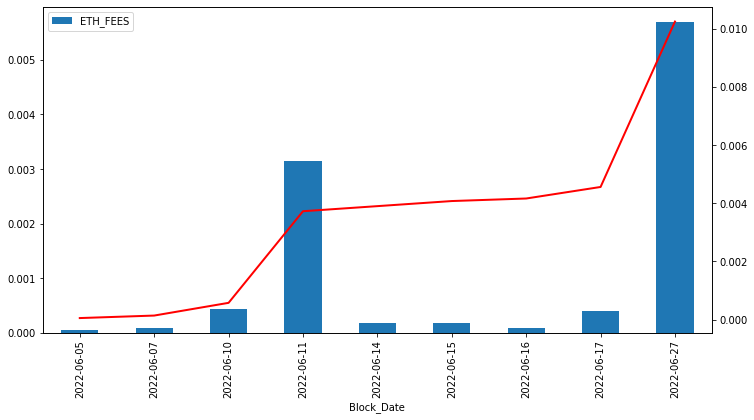

In [7]:
ax1= resulting_df[['ETH_FEES']].plot(
    kind='bar',
    figsize=(12,6)
)
ax2 = ax1.twinx()
ax2.plot(resulting_df[['Accummulative_Eth_Fees']].values, linestyle='-', linewidth=2.0, color='red')

In [8]:
resulting_df.dtypes

ETH_FEES                  float64
AVG_ETH_FEES              float64
Accummulative_Eth_Fees    float64
dtype: object